In [1]:
import sys
sys.path.append('../')
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial
import matplotlib.pyplot as plt
from windows import initInterval, cosine, norm, unnorm
from matrix_builder import generate_indices
from matrix_builder import elmfbpinn 
from matrix_builder_old import elmfbpinn_old
from networks import phi,phi_dx,phi_dxx, phi_old, phi_dx_old, phi_dxx_old
from utils import display_windows

key = random.PRNGKey(0) 

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def exact_solution_cos(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega * t)

def exact_solution_sin(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 1/(omega) *jnp.exp(-delta * t) * jnp.sin(omega * t)

# def harm_u_exact_3(t):
#     return jnp.exp(-delta * t) * jnp.cos(omega * t)

# def harm_u_exact_4(t):
#     return jnp.exp(-delta * t) * jnp.sin(omega * t)

def zero_RHS(t):
    return 0.0 * t

def initWeightBiases(nSubdomains, layer,R=None):
    params_hidden = []  # To store hidden layer parameters
    for i in range(len(layer) - 2):  # Loop through hidden layers only
        key = random.PRNGKey(i)
        w_key_hidden, b_key_hidden, key = random.split(key, 3)
        
        # Calculate weight initialization scale
        if R is None: # He initialization
            v = jnp.sqrt(2. / (layer[i] + layer[i + 1]))
            #jax.debug.print("hidden v: {v}",v=v)
            W = random.uniform(w_key_hidden, (layer[i], layer[i + 1]), minval=-v, maxval=v)
            b = random.uniform(b_key_hidden, (layer[i + 1],), minval=-v, maxval=v)
            
        else: # Random initialization
            key = random.PRNGKey(0)
            w_key_hidden, b_key_hidden, key = random.split(key, 3)
            W = random.uniform(w_key_hidden, (layer[i], layer[i + 1]), minval=-R, maxval=R)
            b = random.uniform(b_key_hidden, (layer[i + 1],), minval=-R, maxval=R)
        
        params_hidden.append((W, b))
    
    # Output layer (unique weights and biases for each subdomain)
    key = random.PRNGKey(len(layer) - 2)  # Ensure a new key for the output layer
    w_key, b_key, key = random.split(key, 3)
    
    if R is None: 
        v = jnp.sqrt(2. / (layer[-2] + layer[-1]))
        #jax.debug.print("outer v: {v}",v=v)
        W_out = random.uniform(w_key, (nSubdomains, layer[-2], layer[-1]), minval=-v, maxval=v)
        b_out = random.uniform(b_key, (nSubdomains, layer[-1]), minval=-v, maxval=v)
    
    else:
        key = random.PRNGKey(0)
        w_key_out, b_key_out, key = random.split(key, 3)
        W_out = random.uniform(w_key, (nSubdomains, layer[-2], layer[-1]), minval=-R, maxval=R)
        b_out = random.uniform(b_key, (nSubdomains, layer[-1]), minval=-R, maxval=R)
    
    params_out = (W_out, b_out)
    
    return params_hidden, params_out, w_key_hidden,b_key_hidden

def initInterval(nSubdomains, xmin, xmax, width=1.9, verbose=False):
    sd = (xmax - xmin) / nSubdomains
    xc = jnp.linspace(xmin, xmax, nSubdomains)
    xmins = xc - width*sd
    xmaxs = xc + width*sd
    if verbose:
        display_windows(xmins, xmaxs)
    return jnp.stack([xmins, xmaxs], axis=-1)

# Normalization and denormalization functions
def norm(mu, sd, x):
    return (x - mu) / sd

def unnorm(mu, sd, x):
    return x * sd + mu

# Forward pass through the neural network
def forward(x, params_hidden, params_outer_layer,sigma):
    for weight, bias in params_hidden:
        x = sigma(jnp.dot(x, weight) + bias)
        
    final_weight, final_bias = params_outer_layer
    return jnp.dot(x, final_weight) + final_bias

# Function to be vmapped across the x points and subdomains
def inner(params_hidden, params_outer_layer, ranges, x, sigma):
    xmin, xmax = ranges
    mu = (xmin + xmax) / 2
    sd = (xmax - xmin) / 2

    w = window_hat(x, xmin, xmax)
    x = norm(mu, sd, x)
    x = forward(x, params_hidden, params_outer_layer, sigma)
    x = unnorm(0, 1, x)

    #jax.debug.print("w: {w}",w=w)  # Printing inside vmap is okay but will be lazy
    #jax.debug.print("x: {x}",x=x)
    evaluation = w * x
    #jax.debug.print("w*x: {evaluation}",evaluation=evaluation)
    return w * x

def cosine(xmin,xmax, x):
    mu, sd = (xmin+xmax)/2, (xmax-xmin)/2
    ws = ((1+jnp.cos(jnp.pi*(x-mu)/sd))/2)**2
    ws = jnp.heaviside(x-xmin,1)*jnp.heaviside(xmax-x,1)*ws
    w = jnp.prod(ws, axis=0, keepdims=True)
    return w

# Partition of Unity window function
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def POU(x, ranges, full_ranges, J): #Fix this later to work with the vmap over ranges?
    xmin, xmax = ranges #Subdomain range
    xmins, xmaxs = full_ranges[:, 0], full_ranges[:, 1] #list of full subdomain ranges
    w_k = jnp.array([cosine(xmins[k], xmaxs[k], x) for k in range(J)])
    w_j = window_hat(xmin, xmax, x)
    return w_j/jnp.sum(w_k)

def model(params, ranges, x, sigma):
    us = jax.vmap(
        jax.vmap(inner, in_axes=(None, None, None, 0, None)),  # Inner vmap for each x
        in_axes=(None, 0, 0, None, None)  # Outer vmap for each subdomain j
    )(params[0], params[1], ranges, x, sigma)

    return jnp.sum(us, axis=0)

#supervised loss
def single_loss_fn(params, ranges, x, y,sigma):
    # Get the model predictions
    u = model(params, ranges, x,sigma)
    
    # Compute the mean squared error loss
    return jnp.mean((u - y) ** 2)

def sum_losses(params, ranges, x, y, sigma):
    loss_fn = lambda y_single: single_loss_fn(params, ranges, x, y_single, sigma)
    losses = jax.vmap(loss_fn)(y)  # Apply single_loss_fn to each y in parallel
    return jnp.sum(losses)


# Training step
#from jax import jit
@partial(jax.jit, static_argnums=(5,6))
def train_step(params, ranges, opt_state, x, y, optimizer,sigma):
    # Compute the gradient of the loss function
    loss, grads = jax.value_and_grad(single_loss_fn, has_aux=False)(params, ranges, x, y,sigma)

    # Apply the updates to the parameters
    updates, opt_state = optimizer.update(grads, opt_state)

    # Apply the updates to the entire params
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss


In [2]:
def basis_pretrain(layer_sizes, J, xmin, xmax, nSamples, epochs, epoch_print, learning_rate, sigma, harm_u_exact=None,R=None):
    # Initialize random key and parameters
    key = random.PRNGKey(0)
    
    # Initialize the weights and biases for the hidden and output layers
    params_hidden, params_out, w_key,b_key = initWeightBiases(J, layer_sizes,R)
    #print(f"hidden weights: {params_hidden[0][0]}")
    #print(f"hidden biases: {params_hidden[0][1]}")
    params = (params_hidden, params_out)
    
    # Initialize the subdomains
    ranges = initInterval(J, xmin, xmax,width=1.9,verbose=False)
    # for r in ranges:
    #     print(f"range: {r}")
    #full_ranges = initInterval(J, xmin, xmax,width=1.9,verbose=False)
    
    # Create training data
    x_train = jnp.linspace(xmin, xmax, nSamples).reshape(-1, 1)
    y_train = harm_u_exact(x_train)
    # y_train_1 = exact_solution_cos(x_train) #Y number of these
    # y_train_2 = exact_solution_sin(x_train) #Y number of these

    # y_train = jnp.stack([y_train_1,y_train_2],axis=0)
    
    # Initialize optimizer (Adam optimizer)
    key, subkey = random.split(key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    # Training loop
    for epoch in range(epochs):
        # Perform one training step
        # print(f"before params: {params}")
        params, opt_state, loss = train_step(params, ranges, opt_state, x_train, y_train, optimizer, sigma)
        #print(f"after params: {params}")
        # Print loss every 1000 epochs
        if epoch % epoch_print == 0:
            print(f"Epoch {epoch}, Loss: {loss:.9f}")
    
    # Return the trained parameters, optimizer state, and final loss
    return params,ranges, opt_state, key, w_key,b_key

In [3]:
layer_sizes = [1, 16, 1]
J = 5
R = 0.24
xmin, xmax = 0, 1
nSamples = 1000
epochs = 10000
epoch_print = epochs/10
learning_rate = 1e-3
# x_train = jnp.linspace(xmin, xmax, nSamples).reshape(-1, 1) #Y number of these
# y_train_1 = exact_solution_cos(x_train) #Y number of these
# y_train_2 = exact_solution_sin(x_train) #Y number of these

# y_train = jnp.stack([y_train_1,y_train_2],axis=0)

# y_train.shape
sin_params, sin_ranges, sin_opt_state,key, w_key,b_key= basis_pretrain(layer_sizes, J, xmin, xmax,nSamples, epochs,epoch_print, learning_rate, jnp.sin, harm_u_exact = exact_solution_sin,R=R)

Epoch 0, Loss: 0.356901377
Epoch 1000, Loss: 0.000045167
Epoch 2000, Loss: 0.000020676
Epoch 3000, Loss: 0.000018675
Epoch 4000, Loss: 0.000018187
Epoch 5000, Loss: 0.000018147
Epoch 6000, Loss: 0.000018146
Epoch 7000, Loss: 0.000018146
Epoch 8000, Loss: 0.000018219
Epoch 9000, Loss: 0.000018145


In [4]:
# import numpy as np

# # Function to evaluate activations of the hidden units
# def get_hidden_activations(x_vals, params,sigma):
#     activations = []
#     x = x_vals
#     for weight, bias in params[0]:  # Iterate over all hidden layers
#         x = sigma(jnp.dot(x, weight) + bias)
#         activations.append(x)
    
#     plt.figure(figsize=(15, 10))
#     for i, activation in enumerate(activations):
#         plt.plot(x_vals, activation, label=f'Hidden Unit {i+1}')
        
#     plt.xlabel('Input x')
#     plt.ylabel('Activation')
#     plt.title(f'Activation of Hidden Units: {sigma.__name__}')
#     plt.grid()
#     plt.show()
#     return activations

In [5]:
# # Generate a set of x values to evaluate the activations
# x_vals = jnp.linspace(0, 1, nSamples).reshape(-1, 1)
# # Get the activations for the hidden units
# hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.sin)


In [6]:
# hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.tanh)# 

### Old Function test

Weights shapes: (4,)
Weights: [ 17.115707 -15.881067 -13.641095 -18.963718]
Biases shapes: (4,)
Biases: [-24.63531   -23.95544     4.0713253  -6.9081   ]
xmins: [-0.38 -0.13  0.12  0.37  0.62]
xmaxs: [0.38 0.63 0.88 1.13 1.38]
Number of neurons C: 4
x_train shape: (150,)
First few x_train values: [0.         0.00671141 0.01342282 0.02013423 0.02684564]
rows shape: (1664,), columns shape: (1664,)
First few rows indices: [0 0 0 0 0]
First few columns indices: [0 1 2 3 4]
Creating M_ode...
Values shape: (Array(1664, dtype=int32, weak_type=True),)
M_values shape: (1664,)
Max of M_values before scaling: 24116.359375
First few values of M_values: [ 11768.533  22365.54  -19574.398 -14223.638   1127.478]
M_values_scaled shape: (1664,)
Max of M_values_scaled: 0.9993042349815369
First few values of M_values_scaled: [ 0.4876501   0.9267559  -0.8111     -0.58938175  0.04671906]
M_ode_sparse shape: (150, 20)
M_ode_sparse non-zero entries: 1664
M_ode created in 0.08 seconds.
exact_solution shape: (1

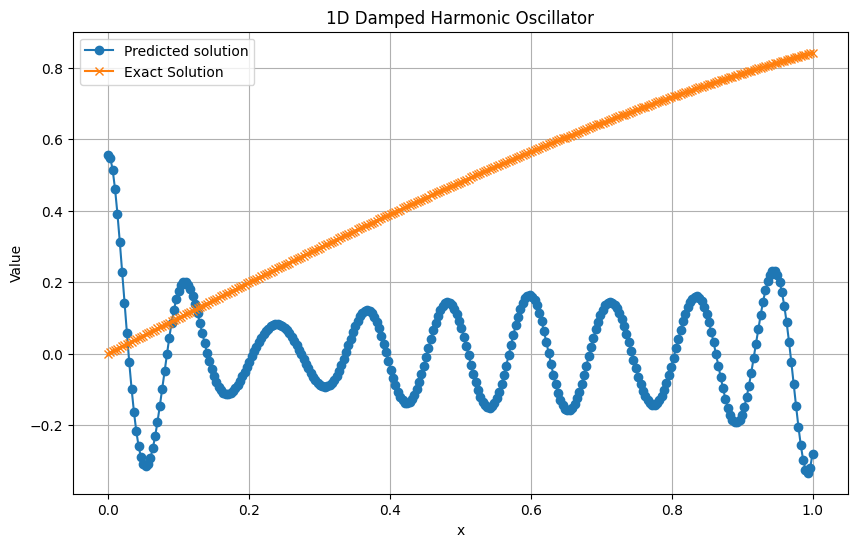

Condition number of M_ode_sparse: 1.54e+04
Condition number of M_sol_sparse: 9.63e+03
Condition Number of LHS: 3.94e+08
Total time taken: 0.43 seconds.


In [9]:
RHS_func = zero_RHS
u_func = jnp.sin
n_train = 150
n_test = 300
J=5
C=4
R=25
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
old_results = elmfbpinn_old(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    # key,
    # w_key_hidden,
    # b_key_hidden,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
    debug=False
)

### Sin params - Initialised, untrained

Weight shapes: [(1, 4)]
Weights: [Array([[ 17.115707, -15.881067, -13.641095, -18.963718]], dtype=float32)]
Bias shapes: [(4,)]
Biases: [Array([-24.63531  , -23.95544  ,   4.0713253,  -6.9081   ], dtype=float32)]
xmins: [-0.38 -0.13  0.12  0.37  0.62]
xmaxs: [0.38 0.63 0.88 1.13 1.38]
Number of neurons C: 4
x_train shape: (150,)
First few x_train values: [0.         0.00671141 0.01342282 0.02013423 0.02684564]
rows shape: (1664,), columns shape: (1664,)
First few rows indices: [0 0 0 0 0]
First few columns indices: [0 1 2 3 4]
Creating M_ode...
M_values shape: (1664,)
Max of M_values before scaling: 24116.359375
First few values of M_values: [ 11768.533   22365.54   -19574.398  -14223.638    1127.4781]
M_values_scaled shape: (1664,)
Max of M_values_scaled: 0.9993042349815369
First few values of M_values_scaled: [ 0.4876501   0.9267559  -0.8111     -0.58938175  0.04671906]
M_ode_sparse shape: (150, 20)
M_ode_sparse non-zero entries: 1664
M_ode created in 0.07 seconds.
Exact solution sha

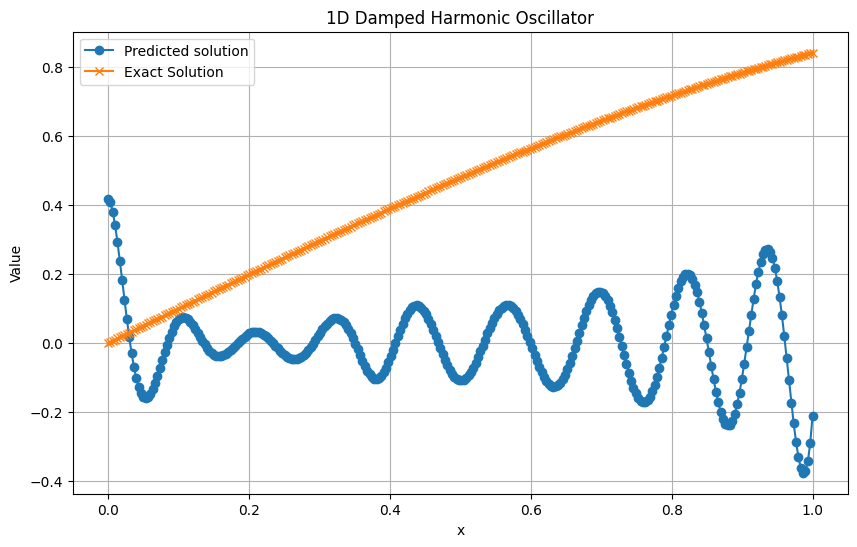

Condition number of M_ode_sparse: 1.54e+04
Condition number of M_sol_sparse: 9.63e+03
Condition number of LHS: 1.58e+08
Total time taken: 0.36 seconds.


In [10]:

RHS_func = zero_RHS
u_func = jnp.sin
n_train = 150
n_test = 300
J=5
C=4
R=25
params_hidden, params_out, w_key_hidden,b_key_hidden = initWeightBiases(J,[1,C,1],R)
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"

untrained_results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    sin_ranges,
    xmin,
    xmax,
    width,
    sigma,
    title,
    params_hidden,
    lmda=1,
    plot_window=False,
    debug=False,
)

In [14]:
old_lsq, Ms, B, old_a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time, rows, columns = old_results
new_lsq, Ms, B, new_a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time, rows, columns = untrained_results

old_M_ode_sparse, old_B_ode_scaled, old_lmda, old_exact_solution, old_g_train = old_lsq
new_M_ode_sparse, new_B_ode_scaled, new_lmda, new_exact_solution, new_g_train = new_lsq

In [15]:
old_M_ode_sparse.toarray()

array([[ 5.05350888e-01,  9.60395396e-01, -8.40541422e-01,
        -6.10775173e-01,  4.84148748e-02,  6.94522411e-02,
        -5.88777699e-02, -5.67502528e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.71353918e-01, -3.56536359e-01,  3.62390399e-01,
        -2.88361788e-01,  3.28717828e-01, -3.22398037e-01,
         3.20918024e-01, -1.69760510e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.28414363e-01, -1.15279093e-01,  1.35202706e-01,
         1.46426022e-01, -9.36551750e-01, -7.08991826e-01,
         8.79193902e-01,  9.89769161e-01, -3.46409120e-02,
        -2.07724869e-02,  2.8

In [16]:
new_M_ode_sparse.toarray()

array([[ 5.05350888e-01,  9.60395396e-01, -8.40541422e-01,
        -6.10775173e-01,  4.84148785e-02,  6.94522411e-02,
        -5.88777699e-02, -5.67502528e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.71353918e-01, -3.56536359e-01,  3.62390399e-01,
        -2.88361788e-01,  3.28717828e-01, -3.22398037e-01,
         3.20918024e-01, -1.69760510e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.28414363e-01, -1.15279093e-01,  1.35202706e-01,
         1.46426037e-01, -9.36551750e-01, -7.08991826e-01,
         8.79193902e-01,  9.89769161e-01, -3.46409120e-02,
        -2.07724869e-02,  2.8

### Sin params - Trained

In [26]:
params_hidden, params_out = sin_params
hidden_weights = params_hidden[0][0]

hidden_weights

Array([[ 0.16331078, -0.15145826, -0.12995452, -0.1810517 , -0.14892952,
         0.10556722,  0.12841387, -0.1657806 ,  0.21781899, -0.22693096,
        -0.19161895,  0.02450878, -0.18126537,  0.04638977,  0.22155555,
         0.09174905,  0.10856604, -0.0882811 ,  0.15463428,  0.0666926 ,
        -0.11476634, -0.14683232,  0.13342746,  0.16991638,  0.1537144 ,
        -0.09160166,  0.1511737 ,  0.21702655, -0.23615025,  0.08092449,
         0.22439934, -0.1812224 ]], dtype=float32)

hidden_weights: [[ 0.40264437 -0.57057035 -0.7237771  -0.76440257 -0.02581475 -0.02195944
   0.3907823  -0.5805148   0.26578444 -0.26964483 -0.5677179   0.29615977
  -0.18462445  0.27579522  0.48575523  0.18989462]]
hidden_biases: [-0.23151197 -0.25939307  0.28823367 -0.21689443 -0.05360645 -0.24076124
 -0.41771576  0.02664901 -0.31247628  0.17990603 -0.16049218  0.2769812
 -0.10487657  0.02177306 -0.03242779  0.07375254]
xmins: [-0.095      -0.04236842  0.01026316  0.06289473  0.11552632  0.1681579
  0.22078946  0.27342105  0.32605264  0.37868422  0.4313158   0.48394737
  0.5365789   0.5892105   0.6418421   0.69447374  0.74710524  0.79973686
  0.8523685   0.905     ]
xmaxs: [0.095      0.14763159 0.20026316 0.25289473 0.30552632 0.3581579
 0.41078946 0.46342105 0.5160526  0.5686842  0.62131584 0.67394733
 0.72657895 0.77921057 0.83184206 0.8844737  0.9371053  0.9897368
 1.0423684  1.095     ]
Number of neurons C: 16
x_train shape: (150, 1)
x_train range: [0.] to [1.]
rows shape: (8416

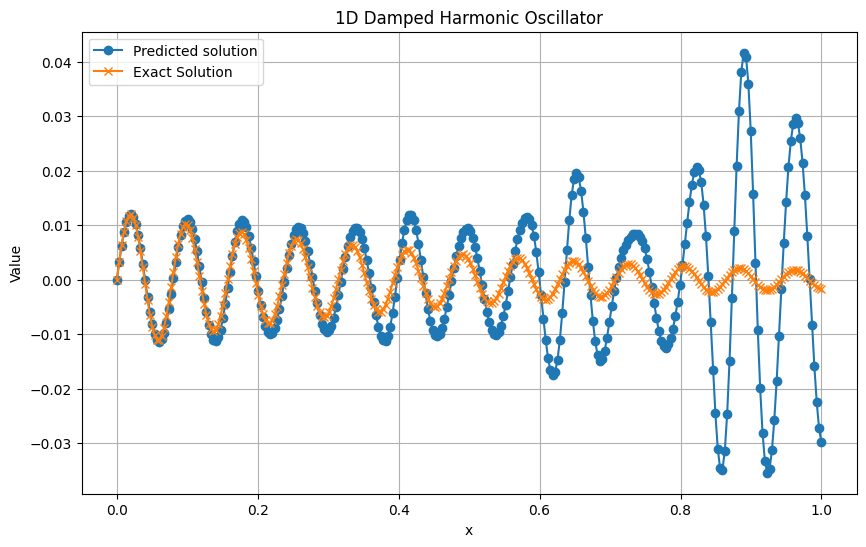

Condition number of M_ode_sparse: 1.05e+10
Condition number of M_sol_sparse: 4.64e+11
Condition number of LHS: 3.18e+11
Total time taken: 5.78 seconds.


In [40]:
params_hidden, params_out = sin_params
hidden_weights = params_hidden[0][0]
a_pre_trained = params_out[0][0]
hidden_biases = params_hidden[0][1]

RHS_func = zero_RHS
u_func = exact_solution_sin
n_train = 150
n_test = 300
J=20
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
trained_results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    sin_ranges,
    xmin,
    xmax,
    width,
    sigma,
    title,
    params_hidden,
    lmda=1,
    plot_window=False,
    debug=True,
)

In [66]:
trained_Ms, trained_B, elm_a, trained_u, trained_loss, trained_x, trained_f, trained_lhs_condition, trained_xmins, trained_xmaxs, trained_total_elapsed_time, trained_rows, trained_columns = old_results

In [71]:
params_hidden, params_out = sin_params
hidden_weights = params_hidden[0][0]
a_pre_trained = params_out[0]
hidden_biases = params_hidden[0][1]

In [63]:
elm_a
a_pre_trained = params_out[0][0]

In [74]:
elm_a.shape

(320,)

In [82]:
a_pre_trained = a_pre_trained.reshape(-1,1).flatten()

In [86]:
a_pre_trained - elm_a

Array([ 7.67247155e-02, -2.92148888e-01,  5.28113693e-02, -1.21656060e-01,
       -2.12850764e-01,  2.06734523e-01, -2.70507514e-01, -9.98999923e-02,
        4.49172676e-01,  7.59029165e-02,  2.34285161e-01, -2.77928978e-01,
        2.90927887e-02, -1.49229560e-02, -1.15608943e+00, -2.20214248e-01,
       -4.52478789e-02, -3.26633453e-05, -1.50388539e+00,  2.99197406e-01,
       -7.70053267e-03, -4.01194513e-01,  1.76479340e-01, -2.85091400e-01,
        2.31949374e-01, -4.19111922e-02, -7.31274903e-01,  1.98664963e-01,
       -3.22648436e-02,  5.68668097e-02, -1.16257221e-01, -5.39029017e-02,
        9.81244445e-03, -2.51877904e-01, -1.64241838e+00, -7.95708537e-01,
        2.64321685e-01, -3.56337011e-01, -2.01502115e-01, -1.13273335e+00,
        3.17461371e-01,  3.47343504e-01,  6.96171641e-01, -1.53105721e-01,
       -1.45922735e-01, -3.58536720e-01, -4.37809080e-01, -2.24107087e-01,
       -2.66341269e-02, -3.73647809e-02,  2.64933085e+00,  2.93391943e-03,
        1.16716221e-01,  

In [85]:
elm_a

array([ 3.74975801e-03,  1.52625471e-01,  1.66533947e-01, -2.65648812e-02,
       -2.26118714e-02, -2.41858959e-02,  3.29289734e-01,  6.16905391e-02,
       -3.74904931e-01, -1.10798344e-01, -4.40177917e-02,  1.71267718e-01,
       -1.72957778e-01,  6.46062242e-03,  9.24612105e-01,  3.75622660e-01,
       -4.10430250e-04, -1.32246256e-01,  1.43736553e+00, -5.98267019e-02,
        2.56682187e-02,  2.25765392e-01,  1.36479437e-01,  2.29075491e-01,
       -3.57261114e-02,  8.29410106e-02,  8.89143646e-01, -1.27834201e-01,
       -1.04037732e-01,  1.40262231e-01,  2.61005968e-01,  1.72507048e-01,
        1.28373608e-01,  1.54383674e-01,  1.71665013e+00,  8.99934888e-01,
       -2.62331724e-01,  8.97809416e-02,  1.66579828e-01,  9.73181605e-01,
       -1.95478126e-01, -9.60317850e-02, -5.87443292e-01,  1.67551786e-02,
       -1.56935751e-02,  8.32448304e-02,  2.04365492e-01,  4.35364455e-01,
       -1.71931997e-01,  9.99802351e-02, -2.37814236e+00, -8.98032784e-02,
        4.04812098e-02,  

In [ ]:
trained_Ms, trained_B, trained_a, trained_u, trained_loss, trained_x, trained_f, trained_lhs_condition, trained_xmins, trained_xmaxs, trained_total_elapsed_time, trained_rows, trained_columns = trained_results
untrained_Ms, untrained_B, untrained_a, untrained_u, untrained_loss, untrained_x, untrained_f, untrained_lhs_condition, untrained_xmins, untrained_xmaxs, untrained_total_elapsed_time, untrained_rows, untrained_columns = untrained_results

trained_M_sol = trained_Ms[0]
trained_M_ode_sparse = trained_Ms[1]
trained_M_sol_sparse = trained_Ms[2]

untrained_M_sol = untrained_Ms[0]
untrained_M_ode_sparse = untrained_Ms[1]
untrained_M_sol_sparse = untrained_Ms[2]

def max_value(matrix):
    return jnp.max(jnp.abs(matrix))
max_value(trained_M_ode_sparse.toarray())
max_value(untrained_M_ode_sparse.toarray())

#### tanh_params

Creating M_ode...
M_ode created in 1.75 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.67 seconds.
B_train scaled
Time taken for solver: 0.0179 seconds
a calculated in 0.26 seconds.
Creating M_sol...
M_sol created in 1.85 seconds.
Loss Value: 5.66e+04
Test Loss Value: 5.66e+04


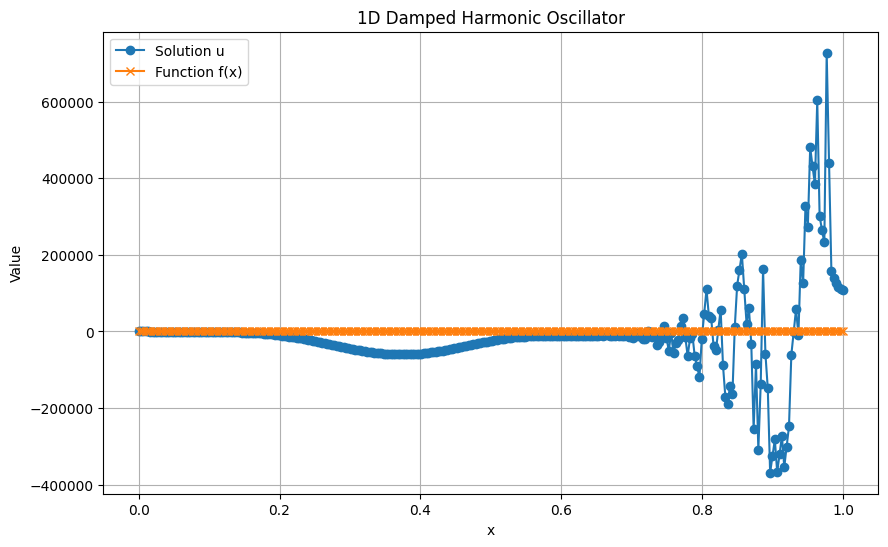

Condition number of M_ode_scaled: 3.04e+11
Condition number of M_sol: 1.47e+29
Condition Number of LHS: inf
Total time taken: 6.80 seconds.


In [13]:
# params_hidden, params_out = tanh_params
# hidden_weights = params_hidden[0][0]
# hidden_biases = params_hidden[0][1]

# RHS_func = zero_RHS
# u_func = harm_u_exact
# n_train = 150
# n_test = 300
# J=20
# width = 1.9
# sigma = jnp.tanh
# xmin,xmax= 0,1
# title = "1D Damped Harmonic Oscillator"
# results = elmfbpinn(
#     RHS_func,
#     u_func,
#     n_train,
#     n_test,
#     J,
#     tanh_ranges,
#     xmin,
#     xmax,
#     width,
#     sigma,
#     title,
#     params_hidden,
#     lmda=1,
#     plot_window=False,
# )

Random weights - tanh

Creating M_ode...
M_ode created in 1.22 seconds.
exact_solution scaled.
Creating B_train...
B_train scaled
Time taken for solver: 0.0104 seconds
a calculated in 0.17 seconds.
Creating M_sol...
M_sol created in 1.23 seconds.
Loss Value: 3.09e-01
Test Loss Value: 3.09e-01


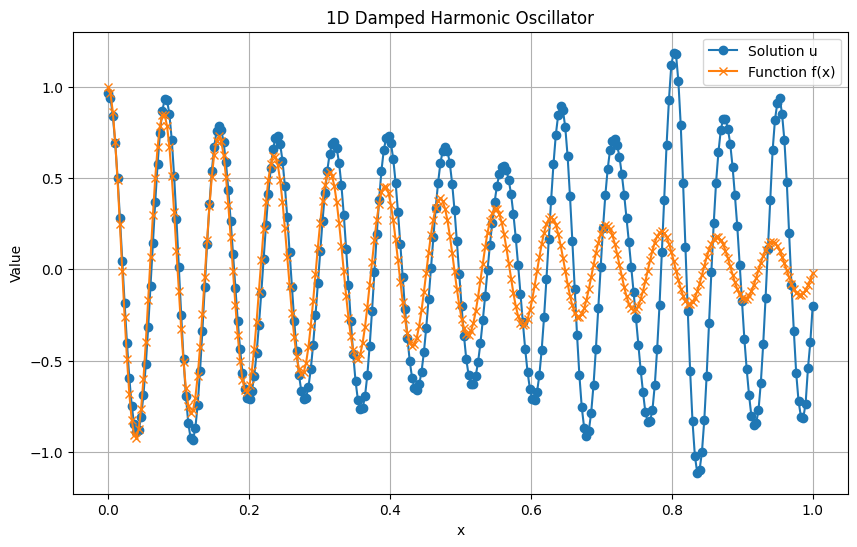

Condition number of M_ode_scaled: 2.80e+10
Condition number of M_sol: 1.48e+12
Condition Number of LHS: 1.52e+12
Total time taken: 4.71 seconds.


In [14]:
# params_hidden, params_out = tanh_params
# hidden_weights = params_hidden[0][0]
# hidden_biases = params_hidden[0][1]

# RHS_func = zero_RHS
# u_func = harm_u_exact
# n_train = 150
# n_test = 300
# J=20
# C=32
# R=0.1
# width = 1.9
# sigma = jnp.tanh
# xmin,xmax= 0,1
# title = "1D Damped Harmonic Oscillator"
# results = elmfbpinn_old(
#     RHS_func,
#     u_func,
#     n_train,
#     n_test,
#     J,
#     C,
#     R,
#     xmin,
#     xmax,
#     width,
#     sigma,
#     title,
#     weights=None,
#     biases=None,
#     lmda=1,
#     plot_window=False,
# )